<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec IFU Pipeline Notebook

**Authors**: Kayli Glidic (kglidic@stsci.edu), Maria Pena-Guerrero (pena@stsci.edu), Leonardo Ubeda (lubeda@stsci.edu); NIRSpec branch<br>
**Last Updated**: April 16, 2025 </br>
**Pipeline Version**: 1.80.0 (Build 11.3, Context jwst_1364.pmap)

**Purpose**:<br>
End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) integral field unit (IFU) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into two folders: science and background, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:<br>
This notebook is set up to use observations of Tarantula Nebula with the G140H, G235H, and G395H grisms obtained by Proposal ID (PID) 2729, Observation 5. This observation has a CYCLING dither pattern with 8 points. These observations do not include nods or background. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-ifu-known-issues#gsc.tab=0) for this build are noted in the notebook.

**Updates**:<br>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/).

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template. </br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* January 7, 2025: Add handling for background and CRDS.
* February 7, 2025: Always construct associations within this notebook, generalize plotting.
* April 16, 2025: Notebook updated to JWST pipeline version 1.18.0 (Build 11.3).


---

## Table of Contents
* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
        * [5.2.1 Calibrating Science Files](#5.2.1-Calibrating-Science-Files)
        * [5.2.2 Calibrating Background Files](#5.2.2-Calibrating-Background-Files)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` Association Files](#6.2-Create-Spec2Pipeline-Association-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
        * [6.3.1 Calibrating Science Files](#6.3.1-Calibrating-Science-Files)
        * [6.3.2 Calibrating Background Files](#6.3.2-Calibrating-Background-Files)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` Association Files](#7.2-Create-Spec3Pipeline-Association-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
* [8. Visualize the Data](#8.-Visualize-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec3Pipeline` Products](#8.2-Display-Spec3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))

---

## 1. Configuration
#### Install dependencies and parameters
To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh Conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_ifu_pipeline python=3.12
    conda activate nirspec_ifu_pipeline
    pip install -r requirements.txt

Set the basic parameters to configure the notebook. These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:<br>

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location. <br><br>
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bg_dir`: Directory where background observation data is stored. <br><br>

* **[Backgroud subtraction methods](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-background-recommended-strategies#gsc.tab=0)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec3`? Uses dedicated background observations.
    * `pixel_bg`: Apply pixel-to-pixel background subtraction in `calwebb_spec2`? This is the default pipeline setting. Uses noded observations.<br><br>

In [1]:
# Basic import necessary for configuration.
# Uncomment logging to hide log information.

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command loging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'ifu_data_02729/Obs005', '')

    # Directory to dedicated background observation data; expects uncalibrated data in
    # bg_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    # bg_dir = os.path.join(basedir, 'ifu_data_02729/Obs002', '')
    bg_dir = ''  # If no dedicated background observation, use an empty string.

# ---------------------------Set Processing Steps----------------------------
# Individual pipeline stages can be turned on/off here. Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True  # Visualize calwebb outputs

# Dedicated Background Processing
dodet1bg = False  # calwebb_detector1
dospec2bg = False # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction be done?
# Dedicated backgrounds can either use master or pixel-based subtraction
# Nodded backgrounds can use only pixel-based subtraction
# If none are selected, data will not be background subtracted.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = False  # Pixel-based background subtraction in spec2.

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server
Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
# os.environ['CRDS_CONTEXT'] = 'jwst_1364.pmap'  # CRDS context for 1.18.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [122]:
# ----------------------General Imports----------------------
import time
import copy
import glob
import asdf
import itertools
import numpy as np
from pprint import pprint

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# -------------------- Astroquery Imports ----------------------
from astroquery.mast import Observations

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec as grd
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
from jdaviz import Cubeviz, Specviz
from specutils import Spectrum1D


<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) •
[Github](https://github.com/spacetelescope/jwst)

</div>

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities
from jwst import datamodels  # JWST pipeline utilities: datamodels.
from jwst.associations import asn_from_list as afl  # Tools for creating association files.
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Define Lvl2 ASN.
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Define Lvl3 ASN.

# Check the default context for the Pipeline version
default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst-1.18.0.dist-info)


JWST Calibration Pipeline Version = 1.18.0
Default CRDS Context for JWST Version 1.18.0: jwst_1364.pmap
Using CRDS Context: jwst_1364.pmap


---

### Define Convience Functions

Define a function that filters files based on detector, filter, and grating.

In [33]:
def get_matching(files, detector, filt, grating, exp_type):
    """
    Filters a list of FITS files to find those with matching 
    detector, filter, and grating for a specified exposure type.

    Parameters
    ----------
    files : list of str
        Paths to FITS files to check.
    detector : str
        Expected value of the DETECTOR keyword.
    filt : str
        Expected value of the FILTER keyword.
    grating : str
        Expected value of the GRATING keyword.
    exp_type : str, optional
        The exposure type to match (default is 'NRS_IFU').

    Returns
    -------
    files_regular : list of str
        Files with matching configuration and IS_IMPRT == False or missing.
    files_imprint : list of str)
        Files with matching configuration and IS_IMPRT == True.
    """
    files_regular, files_imprint = [], []
    for file in files:
        # Skip if EXP_TYPE doesn't match the provided one.
        if fits.getval(file, 'EXP_TYPE') != exp_type:
            files_regular.append(file)
            continue
        # Check if DETECTOR, FILTER, and GRATING match
        if (fits.getval(file, 'DETECTOR') == detector and
            fits.getval(file, 'FILTER') == filt and
            fits.getval(file, 'GRATING') == grating):
            # Only IFU and MOS observations can have imprint exposures.
            is_imprt = fits.getval(file, 'IS_IMPRT', default=False)
            (files_imprint if is_imprt else files_regular).append(file)
    return files_regular, files_imprint

Define a function that checks the grating wheel tilt value between two files.

In [9]:
def match_gwa(file1, file2):
    """
    Check if GWA tilt values match closely enough to be associated.
    
    Parameters
    ----------
    file1, file2 : str 
        Input exposures FITS file paths.

    Returns
    -------
    True if both GWA tilt values match within tolerance, else False.
    """
    hdr1, hdr2 = fits.getheader(file1), fits.getheader(file2)
    return np.allclose(
        (hdr1['GWA_XTIL'], hdr1['GWA_YTIL']),
        (hdr2['GWA_XTIL'], hdr2['GWA_YTIL']),
        atol=1e-8, rtol=0
    )


In [10]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---
## 3. Demo Mode Setup (ignore if not using demo data)
<div class="alert alert-block alert-info">

The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit the
[astroquery](https://astroquery.readthedocs.io/en/latest/index.html) documentation.

</div>


If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The IFU demo data in this notebook is from the [Early Release Science (ERS) Proposal ID 2729](https://www.stsci.edu/jwst/science-execution/program-information?id=2729) and features observations of the Tarantula Nebula (extended source) using multiple grisms. The program setup is briefly summarized in the table below.

| Demo Target: Tarantula Nebula | | |
|:-----------:|:-------:|:---:|
| Proposal ID | 02729 | Program number |
| OBSERVTN | 005 | Observation number |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-ifu-spectroscopy) | G140H/F100LP | λ: 0.97–1.89 μm (a medium resolution, R ~ 1000) |
|                | G235H/F170LP | λ: 1.66–3.17 μm (a high resolution, R ~ 2700) |
|                | G395H/F290LP | λ: 2.87–5.27 μm (a high resolution, R ~ 2700) |
| SUBARRAY | SUBS200A1 | Subarray used |
| NINTS | 2 | Number of integrations in exposure |
| NGROUPS | 30 | Number of groups in integration |
|   DURATION  | 87.533 [s] | Total duration of one exposure |
|   READPATT  | NRSIRS2RAPID | Readout Pattern |
|   PATTTYPE  | CYCLING | Primary dither pattern type |
|   PATTSIZE  | LARGE | Primary dither pattern size (1.0" extent) |
|   NUMDTHPT  | 8 | Total number of points in pattern |
|   SRCTYAPT  | UNKNOWN | Source Type selected in APT |

> **Note:** The presence of a physical gap between detectors affects high-resolution IFU observations because the spectra are long enough to span both NIRSpec detectors. When using the grating-filter combination G140H/F070LP (or PRISM/CLEAR) the resulting spectra do not have any gaps because the spectra do not extend beyond NRS1. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-ifu-operations/nirspec-ifu-wavelength-ranges-and-gaps#NIRSpecIFUWavelengthRangesandGaps-Wavelengthgaps)

In [11]:
# Set up the program information and directories to collect
# the data in demo_mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # For non public data sets, you may need to provide a token.
    # However, for security it is not recommended to enter tokens into
    # a terminal or Jupyter notebook.
    #Observations.login(token="")

    # --------------Program and observation information--------------
    program = "02729"
    sci_observtn = "005"
    bg_observtn = None
    # Possible filter options ["F100LP;G140H","F170LP;G235H","F290LP;G395H"].
    # Limiting selection to one.
    filters = ["F290LP;G395H"]

    # ----------Define the base and observation directories----------
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))
    sci_dir = os.path.join(basedir, f'ifu_data_{program}')
    sci_dir = os.path.join(sci_dir, f'Obs{sci_observtn}')
    
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    # If no background observation, leave blank.
    bg_dir = os.path.join(basedir, f'ifu_data_{program}')
    bg_dir = os.path.join(bg_dir, f'Obs{bg_observtn}') if bg_observtn else ''
    uncal_bgdir = os.path.join(bg_dir, 'uncal/') if bg_observtn else ''

    # ------Ensure directories for downloading MAST data exists------
    os.makedirs(uncal_dir, exist_ok=True)
    if bg_observtn:  # only if background observation is provided.
        os.makedirs(uncal_bgdir, exist_ok=True)

else:
    print('Running with user provided data.')

Running in demonstration mode. Example data will be downloaded from MAST!


<br>Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile tables of files from MAST associated with the science (SCI) and, if applicable, background (BG) observations.

In [12]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/IFU'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

    # ------------------BACKGROUND Observation-------------------
    if bg_observtn:
        bg_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/IFU'],
                                                      provenance_name=["CALJWST"],
                                                      obs_id=[f'*{program}*{bg_observtn}*'])

Filter these tables to identify uncalibrated data from MAST.

The demo dataset consists of eight `_uncal.fits` files (per detector), each approximately 63 MB in size. 

In [13]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:
    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads, bg_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # Filter for full-size background files (exclude smaller confirmation images).
    if bg_observtn:
        for exposure in bg_obs_id_table:
            bg_products = Observations.get_product_list(exposure)

            avg_bg_size = np.nanmean(bg_products['size'])
            bg_products = bg_products[bg_products['size'] > avg_bg_size]
            bg_downloads.extend(pfilter(bg_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}

    if bg_observtn:
        bg_downloads = {f for f in bg_downloads if f"jw{program}{bg_observtn}" in f}
        print(f"Background files selected for downloading: {len(bg_downloads)}")
    else:
        print("Background files selected for downloading: 0")

    print(f"Science files selected for downloading: {len(sci_downloads)}")

Background files selected for downloading: 0
Science files selected for downloading: 16


Download the data. 

<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [14]:
# Download data and place them into the appropriate directories.

if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in bg_downloads:
        bg_manifest = Observations.download_file(file, local_path=uncal_bgdir)

2025-04-16 19:58:03,498 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs2_uncal.fits with expected size 65586240.
2025-04-16 19:58:03,614 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs2_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs2_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs2_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:03,720 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs1_uncal.fits with expected size 65586240.
2025-04-16 19:58:03,829 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs1_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs1_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs1_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:03,941 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs2_uncal.fits with expected size 65586240.
2025-04-16 19:58:04,060 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs1_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs2_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs1_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:04,162 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs1_uncal.fits with expected size 65586240.
2025-04-16 19:58:04,279 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs2_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs1_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00004_nrs2_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:04,383 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs1_uncal.fits with expected size 65586240.
2025-04-16 19:58:04,503 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs1_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs1_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00005_nrs1_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:04,612 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs2_uncal.fits with expected size 65586240.
2025-04-16 19:58:04,724 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs2_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00007_nrs2_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00008_nrs2_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:04,846 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs2_uncal.fits with expected size 65586240.
2025-04-16 19:58:04,945 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs1_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs2_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs1_uncal.fits with expected size 65586240. [astroquery.query]


2025-04-16 19:58:05,066 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs1_uncal.fits with expected size 65586240.
2025-04-16 19:58:05,194 - stpipe - INFO - Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs2_uncal.fits with expected size 65586240.


INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00006_nrs1_uncal.fits with expected size 65586240. [astroquery.query]
INFO: Found cached file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs2_uncal.fits with expected size 65586240. [astroquery.query]


---
## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [15]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Association files.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.

os.makedirs(asn_dir, exist_ok=True)
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

# ---------------------------Background Directories-----------------------------
uncal_bgdir = os.path.join(bg_dir, 'uncal/')  # Uncalibrated pipeline inputs.
asn_bgdir = os.path.join(bg_dir, 'asn/')  # Association files.
det1_bgdir = os.path.join(bg_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_bgdir = os.path.join(bg_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.

if bg_dir:
    os.makedirs(asn_bgdir, exist_ok=True)
    os.makedirs(det1_bgdir, exist_ok=True)
    os.makedirs(spec2_bgdir, exist_ok=True)

In [16]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1-time0)/60.0, 1):0.4f} min")

Runtime so far: 7.6000 min


---
## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing.

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec IFU:

* `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
* `dq_init` : Initializes the data quality (DQ) flags for the input data.
* `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
* `superbias` : Subtracts the superbias reference file from the input data.
* `refpix` : Use reference pixels to correct bias drifts.
* `linearity` : Applies a correction for non-linear detector response.
* `dark_current` : Subtracts the dark current reference file from the input data.
* `jump` : Performs CR/jump detection on each ramp integration within an exposure.
* `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
* `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
* `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for IFU data.

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>

In [17]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'], det1dict['jump'] = {}, {}, {}
det1dict['clean_flicker_noise'], det1dict['ramp_fit'] = {}, {}
det1dict['gain_scale'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing for jump step (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'

In [18]:
# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2).

<div class="alert alert-info">

Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

In [19]:
# Turn on 1/f noise correction in Stage 1? (off by default).
#det1dict['clean_flicker_noise']['skip'] = False

<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

---
### 5.2 Run `Detector1Pipeline`

Run the science files and, if available, any background files through the `calwebb_detector1` pipeline using the `.call()` method.

We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 14 minutes to process sixteen `_uncal.fits` files (~1 minutes per file) and generate `_rate.fits` files.

In [20]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))

if bg_dir:
    uncal_bg = sorted(glob.glob(uncal_bgdir + '*uncal.fits'))
    print(f"Background UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_bg))

Science UNCAL Files:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00001_nrs2_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00002_nrs2_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs1_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/uncal/jw02729005001_02101_00003_nrs2_uncal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/

In [21]:
time_det1 = time.perf_counter()  # Tracks runtime for Stage 1.

---

#### 5.2.1 Calibrating Science Files
Identify the input science files and execute the `calwebb_detector1` pipeline using the `call` method.

In [22]:
# Run Stage 1 pipeline on the science using the custom det1dict dictionary.

if dodet1:
    # --------------------------Science UNCAL files--------------------------
    for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):

        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             output_dir=det1_dir)
    print("Stage 1 has been completed for SCI data! \n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00001_nrs1_uncal.fits


2025-04-16 20:05:02,615 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst-1.18.0.dist-info)
2025-04-16 20:05:02,987 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-darkcurrentstep_0005.asdf
2025-04-16 20:05:02,994 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf
2025-04-16 20:05:03,003 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2025-04-16 20:05:03,016 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-04-16 20:05:03,017 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-04-16 20:05:03,017 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-04-16 20:05:03,018 - s

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00001_nrs2_uncal.fits


2025-04-16 20:05:20,266 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00001_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:05:20,271 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:05:20,271 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:05:20,272 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:05:20,272 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00002_nrs1_uncal.fits


2025-04-16 20:05:36,115 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:05:36,118 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.
2025-04-16 20:05:36,118 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.
2025-04-16 20:05:36,119 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.
2025-04-16 20:05:36,119 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00002_nrs2_uncal.fits


2025-04-16 20:05:50,382 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00002_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:05:50,384 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:05:50,385 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:05:50,385 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:05:50,386 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00003_nrs1_uncal.fits


2025-04-16 20:06:05,780 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      ski

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00003_nrs2_uncal.fits


2025-04-16 20:06:20,381 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00003_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:06:20,383 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:06:20,384 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:06:20,384 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:06:20,385 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00004_nrs1_uncal.fits


2025-04-16 20:06:35,549 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      ski

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00004_nrs2_uncal.fits


2025-04-16 20:06:50,746 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00004_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:06:50,749 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:06:50,749 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:06:50,750 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:06:50,750 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00005_nrs1_uncal.fits


2025-04-16 20:07:06,044 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:07:06,046 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.
2025-04-16 20:07:06,046 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.
2025-04-16 20:07:06,047 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.
2025-04-16 20:07:06,047 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00005_nrs2_uncal.fits


2025-04-16 20:07:20,458 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00005_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:07:20,461 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:07:20,461 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:07:20,462 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:07:20,462 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00006_nrs1_uncal.fits


2025-04-16 20:07:35,700 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:07:35,702 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.
2025-04-16 20:07:35,703 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.
2025-04-16 20:07:35,703 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.
2025-04-16 20:07:35,704 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00006_nrs2_uncal.fits


2025-04-16 20:07:51,849 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00006_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:07:51,852 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:07:51,852 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:07:51,853 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:07:51,853 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00007_nrs1_uncal.fits


2025-04-16 20:08:07,573 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:08:07,575 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.
2025-04-16 20:08:07,576 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.
2025-04-16 20:08:07,576 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.
2025-04-16 20:08:07,577 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00007_nrs2_uncal.fits


2025-04-16 20:08:23,636 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00007_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:08:23,639 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:08:23,640 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:08:23,640 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:08:23,641 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00008_nrs1_uncal.fits


2025-04-16 20:08:39,421 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:08:39,423 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.
2025-04-16 20:08:39,424 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.
2025-04-16 20:08:39,424 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.
2025-04-16 20:08:39,425 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Applying Stage 1 Corrections & Calibrations to: jw02729005001_02101_00008_nrs2_uncal.fits


2025-04-16 20:08:53,966 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02729005001_02101_00008_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']
2025-04-16 20:08:53,969 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.
2025-04-16 20:08:53,969 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.
2025-04-16 20:08:53,970 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.
2025-04-16 20:08:53,970 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kglidic/crds_cache/references/jwst/nirspec/

Stage 1 has been completed for SCI data! 



---

#### 5.2.2 Calibrating Background Files

Identify the input background files and execute the `calwebb_detector1` pipeline using the `call` method.

In [23]:
# Run Stage 1 pipeline on any background using the custom det1dict dictionary.

if dodet1bg:
    # ------------------------Background UNCAL files-------------------------
    for uncal_file in sorted(glob.glob(uncal_bgdir + '*uncal.fits')):

        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1bg_result = Detector1Pipeline.call(uncal_file,
                                               save_results=True,
                                               steps=det1dict,
                                               output_dir=det1_bgdir)
    print("Stage 1 has been completed for BKG data! \n")
else:
    print('Skipping Detector1 processing for BKG data.')

Skipping Detector1 processing for BKG data.


---

In [24]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Stage 1: {round((time2-time_det1)/60.0, 1):0.4f} min")

Runtime so far: 16.5000 min
Runtime for Stage 1: 5.3000 min


In [25]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate.fits'))
rateints_sci = sorted(glob.glob(det1_dir + '*_rateints.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci + rateints_sci))

rate_bg = sorted(glob.glob(det1_bgdir + '*_rate.fits'))
rateints_bg = sorted(glob.glob(det1_bgdir + '*_rateints.fits'))
print(f"BACKGROUND | RATE[INTS] Files:\n{'-' * 20}\n" + "\n".join(rate_bg + rateints_bg))

SCIENCE | RATE[INTS] Files:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-not

---
## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
    * `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_s3d.fits`: Resampled 3D IFU cube (ncols x nrows x nwaves).
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).

In Stage 2, each exposure (or association) and detector produces a single file, with multiple extensions corresponding to each source.

The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

<div class="alert alert-info">
Note there has been a bug in the `cube_build` step that caused the point source flux to not be conserved when using different spatial sampling. A fix has been implemented as of release DMS build 9.3/CAL_VER 1.10.2. In order to enable the correct functionality, the units of the `_cal.fits` files and cubes will now be in surface brightness, and only the 1D extracted spectra will be in units of Jy.
</div>

---

### 6.1 Configure `Spec2Pipeline`
The `Spec2Pipeline` has the following steps available for NIRSpec IFU:

* `assign_wcs`: Assigns wavelength solution for spectra.
* `badpix_selfcal`: Flags bad pixels in the input data using a self-calibration technique based on median filtering along the spectral axis.
* `msaflagopen`: Flags pixels in NIRSpec exposures affected by MSA shutters stuck in the open position.
* `nsclean`: Cleans 1/f noise.
* `imprint`: Removes patterns caused by the MSA structure in NIRSpec MOS and IFU exposures.
* `bkg_subtract`: Performs image subtraction for background removal.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `cube_build`: Produces 3D spectral cubes.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for IFU data.

<div class="alert alert-warning">

If pixel-to-pixel background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [27]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal']= {}, {}
spec2dict['msa_flagging'], spec2dict['nsclean'],  = {}, {}
spec2dict['imprint_subtract'], spec2dict['bkg_subtract'] = {}, {}
spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['cube_build'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg
#spec2dict['imprint_subtract']['skip'] = True  # Skip imprint subtraction?

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec2dict['pixel_replace']['skip'] = False
#spec2dict['pixel_replace']['n_adjacent_cols'] = 5
#spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
#spec2dict['nsclean']['skip'] = False
#spec2dict['nsclean']['n_sigma'] = 2

# Turn on bad pixel self-calibration, where all exposures on a given detector 
# are used to find and flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included.
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper'] = 0.005  # Fraction of pixels to flag.


<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the **IFU_NSClean_example** demo notebook for IFU data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---
### 6.2 Create `Spec2Pipeline` Association Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for IFU data can include `science`, `background`, `imprint`, and `selfcal` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background`, `imprint` (leakcals), and `selfcal` files that enable pixel-to-pixel background subtraction, imprint subtraction, and bad pixel self-calibration in `calwebb_spec2`.

Here we construct the necessary association files based on the observing sequence.

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association. Additionally, pixel-to-pixel background subtraction will only be performed if the grating wheel has not moved between the target and off-scene associated background exposures. If the grating wheel moved between the target and background exposures (as would be the case if they were in different visits), pipeline processing will follow a more involved "master background" subtraction done in Stage 3.

</div>

Define a function that associates background, imprint, and selfcal exposures for nodded observations.

In [28]:
def asn_nod(asn, onescifile, sci, sci_imprint, pattnum):
    """
    Associate background, imprint, and selfcal exposures for nodded observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    pattnum : int
        Dither position.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']

    # Assign background exposures.
    for file in sci:
        # If dither position is different from the input position, use it as a background.
        if fits.getval(file, 'PATT_NUM') != pattnum:
            members.append({'expname': file, 'exptype': 'background'})
    
    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSA':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures (only applicable to IFU exposures).
    for file in sci + sci_imprint:
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU':
            members.append({'expname': file, 'exptype': 'selfcal'})

    return asn


Define a function that associates background, imprint, and selfcal exposures for dithered observations.

In [35]:
def asn_dither(asn, onescifile, sci, sci_imprint, bg, bg_imprint):
    """
    Associate background, imprint, and selfcal exposures for dithered observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    bg : list of str
        List of background exposure file paths.
    bg_imprint : list of str
        List of background imprint exposure file paths.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']
    
    # Assign background exposures.
    for file in bg:
        members.append({'expname': file, 'exptype': 'background'})

    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSA':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})
    for file in bg_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSA':
            if match_gwa(bg[0], file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures (only applicable to IFU exposures).
    for file in sci + sci_imprint + bg + bg_imprint:
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU':
            members.append({'expname': file, 'exptype': 'selfcal'})
    
    return asn

Define a function that creates a Level 2 ASN file.

In [48]:
def writel2asn(onescifile, allscifiles, bgfiles, asnfile, product_name, exp_type):
    """
    Create a Level 2 association file for each science exposure.

    Parameters
    ----------
    onescifile : str
        Path to the primary science exposure file.
    allscifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    exp_type : str, optional
        Exposure type to match against (default is 'NRS_IFU').

    Returns
    -------
    True if the association was written successfully, and False otherwise 
    """
    # Define a basic association with the science file.
    # Wrap in array since input was single exposure.
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=product_name)

    # Grab header information from the science file.
    exp_type = fits.getval(onescifile, 'EXP_TYPE')
    if (exp_type == exp_type):
        detector = fits.getval(onescifile, 'DETECTOR')
        grating = fits.getval(onescifile, 'GRATING')
        filt = fits.getval(onescifile, 'FILTER')
        patttype = fits.getval(onescifile, 'PATTTYPE')  # Dither pattern type.
        pattnum = fits.getval(onescifile, 'PATT_NUM')  # Dither pattern number.
        imprint = fits.getval(onescifile, 'IS_IMPRT')  # Imprint exposure?
        
        # If this is an imprint exposure, fail out since those shouldn't be processed alone.
        if imprint:
            return False

    # If the exposure type does not match, fail out 
    # to ensure TA images don't get processed by accident.
    else:
        return False

    # Find all files matching the input configuration and split into regular/imprint.
    use_sci, use_sci_imprint = get_matching(allscifiles, detector, filt, grating, exp_type)
    use_bg, use_bg_imprint = get_matching(bgfiles, detector, filt, grating, exp_type) if bgfiles else ([], [])
    
    # If this uses nodded exposures set up pixel-based background subtraction accordingly.
    is_nod = 'NOD' in patttype.split('-')
    if is_nod:
        asn = asn_nod(asn, onescifile, use_sci, use_sci_imprint, pattnum)
    else:  # Otherwise handle as dithered exposures
        asn = asn_dither(asn, onescifile, use_sci, use_sci_imprint, use_bg, use_bg_imprint)

    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
        
    return True

---
### 6.3 Run `Spec2Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel background subtraction (if desired) here in Stage 2. Otherwise, reduce the backgrounds individually for master background subtraction in Stage 3 (if desired).
</div>

In [30]:
time_spec2 = time.perf_counter()  # Tracks runtime for Stage 2.

---

#### 6.3.1 Calibrating Science Files

Identify the Stage 2 science files and execute the `calwebb_spec2` pipeline using the `call` method.

In [49]:
# To save on runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook 3d cubes/1d spectra for science data.
# Any master background subtraction in spec3 will require the 1d spectra from spec2.
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['cube_build']['skip'] = True  # S2D products.
spec2dict_sci['extract_1d']['skip'] = True  # X1D products.

In [50]:
# Run Stage 2 pipeline using the custom spec2dict_sci dictionary.

if dospec2:
    # --------------------------Science files--------------------------
    for file in rate_sci:
        try: # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_sci, rate_bg, asnfile, 'Level2', 'NRS_IFU'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                     save_results=True,
                                                     steps=spec2dict_sci,
                                                     output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slices fall on NRS2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")
    print("Stage 2 has been completed for SCI data! \n")
else:
    print('Skipping Spec2 processing for SCI data.')

2025-04-16 20:36:58,698 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)

2025-04-16 20:36:58,763 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-16 20:36:58,783 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-16 20:36:58,803 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2025-04-16 20:36:58,804 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-04-16 20:36:58,804 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2025-04-16 20:36:58,805 - stpipe.Spec2Pi

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs1_rate.fits


2025-04-16 20:36:59,468 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00001_nrs2_rate.fits


2025-04-16 20:37:50,711 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs1_rate.fits


2025-04-16 20:38:40,619 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00002_nrs2_rate.fits


2025-04-16 20:39:33,558 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs1_rate.fits


2025-04-16 20:40:24,530 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00003_nrs2_rate.fits


2025-04-16 20:41:18,076 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs1_rate.fits


2025-04-16 20:42:08,020 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00004_nrs2_rate.fits


2025-04-16 20:42:59,265 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs1_rate.fits


2025-04-16 20:43:52,746 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00005_nrs2_rate.fits


2025-04-16 20:44:44,948 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs1_rate.fits


2025-04-16 20:45:35,625 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/asn/jw02729005001_02101_00006_nrs1_l2asn.json',).
2025-04-16 20:45:35,645 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00006_nrs2_rate.fits


2025-04-16 20:46:26,088 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs1_rate.fits


2025-04-16 20:47:16,602 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00007_nrs2_rate.fits


2025-04-16 20:48:09,344 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs1_rate.fits


2025-04-16 20:49:01,321 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Applying Stage 2 Corrections & Calibrations to: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage1/jw02729005001_02101_00008_nrs2_rate.fits


2025-04-16 20:49:53,935 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      

Stage 2 has been completed for SCI data! 



---

#### 6.3.2 Calibrating Background Files
Prepare background files for master background subtraction in Stage 3. Will skip if no background files.

In [51]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

if dospec2bg and master_bg:
    # ---------------------Background ASN or RATE files---------------------
    for file in rate_bg:
        try:
            asnfile = os.path.join(asn_bgdir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_bg, '', asnfile, 'Level2', 'NRS_IFU'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {os.path.basename(file)}")
                spec2bg_result = Spec2Pipeline.call(asnfile,
                                                    save_results=True,
                                                    steps=spec2dict,
                                                    output_dir=spec2_bgdir)
        except Exception as e:
            # A handle for when no slices fall on NRS2.
            print(f"Skipped processing {os.path.basename(file)}: {e}")
    print("Stage 2 has been completed for BKG data! \n")
else:
    print("Skipping Stage 2 for BKG data. \n")

Skipping Stage 2 for BKG data. 



---

In [52]:
# Print out the time benchmarks.
time3 = time.perf_counter()
print(f"Runtime so far: {round((time3-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec2: {round((time3-time_spec2)/60.0, 1):0.4f} min")

Runtime so far: 58.1000 min
Runtime for Spec2: 24.2000 min


In [53]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s3d = sorted(glob.glob(spec2_dir + '*_s3d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S3D Products:\n{'-'*20}\n" + "\n".join(sci_s3d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

# ----------------------------Background files---------------------------
bg_cal = sorted(glob.glob(spec2_bgdir + '*_cal.fits'))
bg_s3d = sorted(glob.glob(spec2_bgdir + '*_s3d.fits'))
bg_x1d = sorted(glob.glob(spec2_bgdir + '*_x1d.fits'))

print(f"BACKGROUND | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(bg_cal))
print(f"BACKGROUND | Stage 2 S3D Products:\n{'-'*20}\n" + "\n".join(bg_s3d))
print(f"BACKGROUND | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(bg_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00001_nrs2_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00002_nrs2_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs1_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage2/jw02729005001_02101_00003_nrs2_cal.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-noteb

---
## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
	* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
    * `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
    * `_s3d.fits`: Resampled 3D IFU cube (ncols x nrows x nwaves).
	* `_x1d.fits`: Extracted 1D spectroscopic data.

In Stage 3, single files are created for each source, one extension in the file.

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection, background subtraction) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 3D spectral product, as well as a combined 1D spectrum.

---
### 7.1 Configure `Spec3Pipeline`

The `Spec3Pipeline` has the following steps available for NIRSpec IFU:

* `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
* `master_background`: Master background subtraction.
* `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `cube_build`: Produces 3D spectral cubes from 2D images.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for IFU data.

<div class="alert alert-warning">
If master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 
</div>

In [54]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'] = {}, {}
spec3dict['outlier_detection'], spec3dict['pixel_replace'] = {}, {}
spec3dict['cube_build'], spec3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here.
spec3dict['master_background']['skip'] = not master_bg

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['n_adjacent_cols'] = 5
#spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Testing found this to be a better kernel size.
# The kernel size must only contain odd values.
spec3dict['outlier_detection']['kernel_size'] = '3 3'

<div class="alert alert-info">

As of DMS build B9.3rc1/CAL_VER 1.11.0, a new outlier detection algorithm for IFU data has been implemented. If using a pipeline version before this build, we recommend that outlier detection be skipped/turned off. To learn more about how the algorithm operates, refer to the documentation [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_ifu.html#outlier-detection-ifu).

</div>

---
### 7.2 Create `Spec3Pipeline` Association Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for IFU data can include `science` and `background` exposure types. A Stage 3 ASN file requires at least one `science` file (there is usually more than one) but can contain multiple `background` files that enable master background subtraction in `calwebb_spec3`. **Note that the science exposures should be in the `_cal.fits` format, while the background exposures must be in the `_x1d.fits` format.**

Exposures from multiple filter/grating settings can be included in the same association file, but the pipeline will treat them independently and create output products for each.

In [57]:
def writel3asn(scifiles, bgfiles, asnfile, product_name):
    """
    Create a Level 3 association file.

    Parameters
    ----------
    scifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    
    Returns
    -------
    None.
    """
    # Define the basic association of science files.
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=product_name)

    # Add background files to the association.
    for file in bgfiles:
        asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})

    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [58]:
spec3_asn = os.path.join(asn_dir, 'l3asn.json')
if dospec3:
    writel3asn(sci_cal, bg_x1d, spec3_asn, 'Level3')

2025-04-16 20:53:45,467 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



---
### 7.3 Run `Spec3Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec3` pipeline using the `.call()` method.

In [59]:
time_spec3 = time.perf_counter()

In [60]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

if dospec3:
    print(f"Applying Stage 3 Corrections & Calibrations to: "f"{os.path.basename(spec3_asn)}")
    spec3_result = Spec3Pipeline.call(spec3_asn,
                                      save_results=True,
                                      steps=spec3dict,
                                      output_dir=spec3_dir)
    print("Stage 3 has been completed! \n")
else:
    print("Skipping Stage 3. \n")

Applying Stage 3 Corrections & Calibrations to: l3asn.json


2025-04-16 20:53:49,148 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0001.asdf
2025-04-16 20:53:49,157 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf
2025-04-16 20:53:49,181 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-04-16 20:53:49,182 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-04-16 20:53:49,182 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2025-04-16 20:53:49,183 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2025-04-16 20:53:49,184 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-04-16 20:53:49,185 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2025-04-16 20:53:

Stage 3 has been completed! 



In [61]:
# Print out the time benchmarks.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec3: {round((time4-time_spec3)/60.0, 1):0.4f} min")

Runtime so far: 72.3000 min
Runtime for Spec3: 11.2000 min


In [62]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_crf.fits'))
stage3_s3d = sorted(glob.glob(spec3_dir + '*_s3d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-'*20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-'*20}\n" + "\n".join(stage3_s3d))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs1_a3001_crf.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00001_nrs2_a3001_crf.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs1_a3001_crf.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00002_nrs2_a3001_crf.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003_nrs1_a3001_crf.fits
/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jw02729005001_02101_00003_nrs2_a3001_crf.fits
/Users/kglidic/Documents/pi

---
## 8. Visualize the Data
Define convenience funcitons for visualization. For some plots we utilize [`jdaviz`](https://jdaviz.readthedocs.io/en/stable/index.html), a package of astronomical data analysis visualization tools designed to work in Jupyter notebooks.

Define a function to display Stage 1 products.

In [63]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.

    Returns
    -------
    None.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

--- 

### 8.1 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products.

[Jdaviz Rampviz](https://jdaviz.readthedocs.io/en/stable/rampviz/index.html) is a visualization and analysis toolbox for ramp cubes from infrared detectors and is currently under active development. Until it's fully available, we can plot Stage 1 products using `display_rate`.

2025-04-16 22:39:09,107 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2025-04-16 22:39:09,354 - stpipe - WARNING - /tmp/ipykernel_21814/2477700640.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



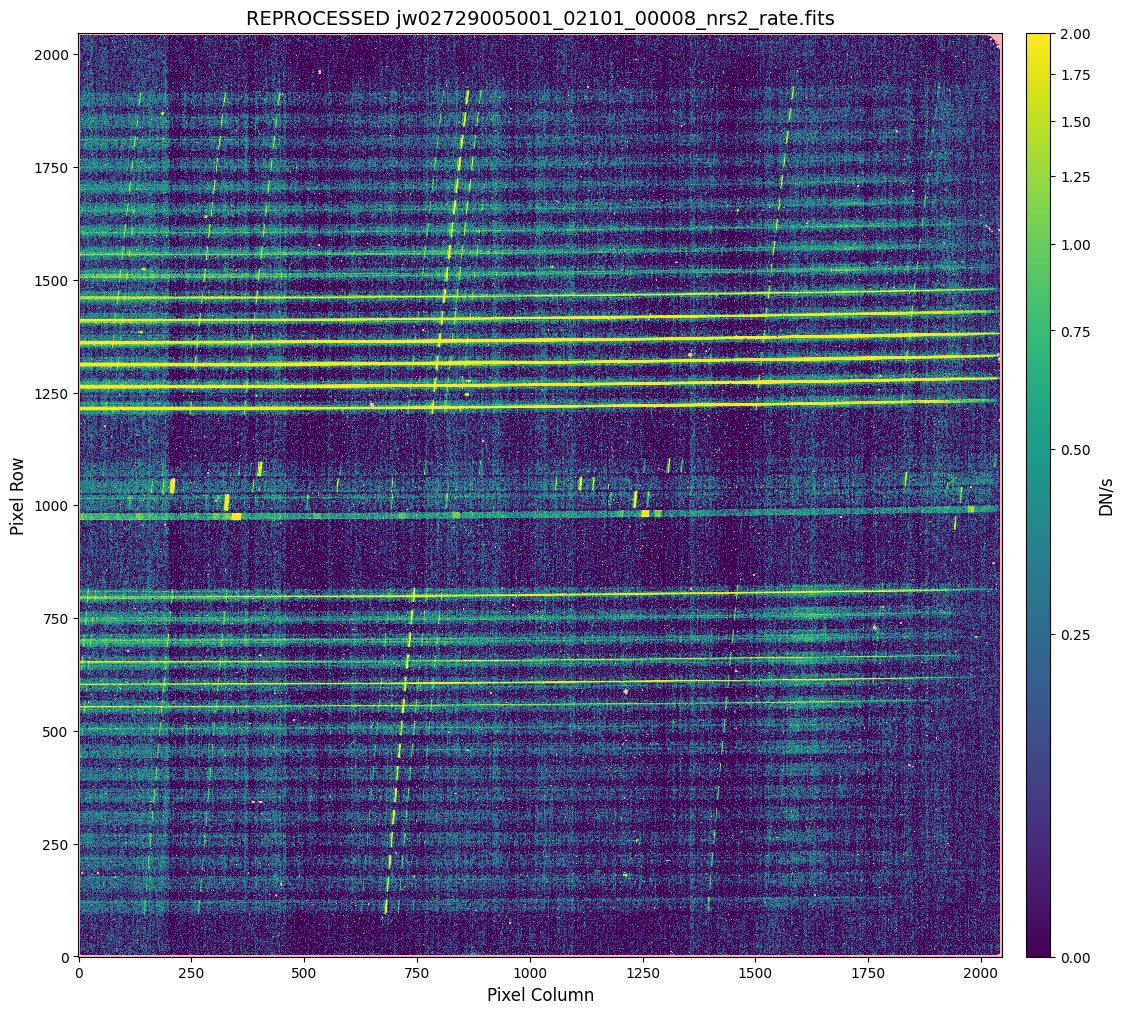

In [123]:
rate_file = rate_sci[-1]  # Show the last rate file, as an example.
display_rate(rate_file, vmin=0, vmax=2, scale='asinh',
             aspect=1, title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec3Pipeline` Products
Use Jdaviz [Cubeviz](https://jdaviz.readthedocs.io/en/stable/cubeviz/index.html) and [Specviz](https://jdaviz.readthedocs.io/en/stable/specviz/index.html) to visualize and analyze the Stage 3 combined calibrated spectra. For more information on these visualization tools and plotting capabilities, refer to the official documentation linked.

In [ ]:
# Plot the Stage 3 IFU cube with Cubeviz.
cubeviz = Cubeviz()
cube = stage3_s3d[0]
cubeviz.load_data(cube, data_label='Level 3 IFU Product: 3D Cube')
cubeviz.show()

2025-04-16 22:43:49,559 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-OBS to '2022-06-20T20:32:00.974' from MJD-OBS.
Set DATE-BEG to '2022-06-20T20:32:00.974' from MJD-BEG.
Set DATE-AVG to '2022-06-20T20:44:39.664' from MJD-AVG.
Set DATE-END to '2022-06-20T20:57:18.330' from MJD-END'.
  warnings.warn(

2025-04-16 22:43:49,561 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -75.103530 from OBSGEO-[XYZ].
Set OBSGEO-B to   -36.557942 from OBSGEO-[XYZ].
Set OBSGEO-H to 1724200998.176 from OBSGEO-[XYZ]'.
  warnings.warn(

2025-04-16 22:43:49,847 - stpipe - WARNING - /opt/anaconda3/envs/jwst_1.18.0/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-OBS to '2022-06-20T20:32:00.974' from MJD-OBS.
Set DATE-BEG t

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/cubeviz/index.html', events=[…

In [ ]:
# Plot the Stage 3 1D spectrum with Specviz.
spec1d = Spectrum1D.read(stage3_x1d[0])
specviz = Specviz()
specviz.load_data(spec1d, data_label="Level 3 IFU Product: Extracted 1D Spectrum")
specviz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/specviz/index.html', events=[…

In [ ]:
time5 = time.perf_counter()
print(f"Runtime so far: {round((time5-time0)/60.0, 1):0.4f} min")

---

## 9. Modifying the EXTRACT1D Reference File (as needed)

The `extract_1d` step is controlled by a different set of parameters in the EXTRACT1D reference file for extended vs. point source IFU data. 

[Extraction for 3D IFU Data:](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

> * For extended sources, rectangular aperture photometry is used, with the entire image extracted and no background subtraction, regardless of what is specified in the reference file or step arguments.
> * For point source data, the extraction aperture is centered at the RA/DEC target location indicated by the header. If the target location is undefined in the header, then the extraction region is the center of the IFU cube.
> * For point sources, a circular extraction aperture is used, along with an optional circular annulus for background extraction and subtraction. The size of the extraction region and the background annulus size varies with wavelength. The extraction-related vectors are found in the ASDF EXTRACT1D reference file. For each element in the wavelength vector, there are three size components: `radius`, `inner_bkg`, and `outer_bkg`. The radius vector sets the extraction size while `inner_bkg` and `outer_bkg` specify the limits of an annular background aperture. 

Below is an example of how to modify the EXTRACT1D reference file for point sources. More information about this file and how to modify it in [extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) and
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data).

<div class="alert alert-block alert-info">

The `ifu_autocen` parameter provides a new method to center on the point sources even if the header information is imperfect due to inaccuracies caused by, e.g., FGS.

</div>

<div class="alert alert-block alert-danger">
    
**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `radius` parameter **MUST** remain unchanged for point source to ensure proper flux calibration!

</div>

In [125]:
# If you don't know the reference file name this should work.
#extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s3d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0002.asdf'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0002.asdf']

# Construct the modified file name
basename = os.path.basename(extract_1d_ref)[:-5]  # Remove ".asdf"
extract_1d_ref_mod = os.path.join(spec3_dir, f"{basename}_demo.asdf")

print('Original x1d reference file', extract_1d_ref)
print('Modified x1d reference file', extract_1d_ref_mod)

# Open the original ASDF file, modify it, and save the modified version
# in your current directory.
with asdf.open(extract_1d_ref, mode='r') as ref_file:
    # Create a copy of the original tree
    tree = ref_file.tree.copy()

    # Modify the tree.
    tree['data']['radius'] = np.full((2048,), 0.45, dtype='float32')
    tree['data']['inner_bkg'] = np.full((2048,), 1.0, dtype='float32')
    tree['data']['outer_bkg'] = np.full((2048,), 1.2, dtype='float32')

    # Save the modified tree to a new file.
    with asdf.AsdfFile(tree) as new_file:
        new_file.write_to(extract_1d_ref_mod, all_array_storage='inline')

Original x1d reference file /Users/kglidic/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0002.asdf
Modified x1d reference file /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/jwst_nirspec_extract1d_0002_demo.asdf


In [126]:
# Check modified file contents.
with asdf.open(extract_1d_ref_mod) as ref_file:
    # Pretty-print the ASDF tree structure.
    pprint(ref_file.tree, depth=4)

{'asdf_library': {'author': 'The ASDF Developers',
                  'homepage': 'http://github.com/asdf-format/asdf',
                  'name': 'asdf',
                  'version': '4.1.0'},
 'data': {'inner_bkg': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
          'inner_bkg_units': 'arcsec',
          'outer_bkg': array([1.2, 1.2, 1.2, ..., 1.2, 1.2, 1.2], dtype=float32),
          'outer_bkg_units': 'arcsec',
          'radius': array([0.45, 0.45, 0.45, ..., 0.45, 0.45, 0.45], dtype=float32),
          'radius_units': 'arcsec',
          'wavelength': array([0.6       , 0.60229605, 0.6045921 , ..., 5.2954082 , 5.297704  ,
       5.3       ], dtype=float32),
          'wavelength_units': 'micron'},
 'history': {'entries': [{'description': 'Update to asdf format as per JIRA '
                                         'issue JP-1730',
                          'time': datetime.datetime(2020, 12, 18, 23, 4, 39)},
                         {'description': 'Update parameters to 

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.

In [127]:
for s3d in stage3_s3d:
    Extract1dStep.call(s3d,
                       save_results=True,
                       output_dir=spec3_dir,
                       output_use_model=True,
                       suffix='x1d_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       ifu_autocen=False, # Set this to True for isolated point sources
                       override_extract1d=extract_1d_ref_mod)

2025-04-16 22:45:00,351 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2025-04-16 22:45:00,863 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/Level3_g395h-f290lp_s3d.fits',).
2025-04-16 22:45:00,865 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/kglidic/Documents/pipeline/jwst-pipeline-notebooks/notebooks/NIRSPEC/IFU/ifu_data_02729/Obs005/stage3/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_inc

We now plot again the 3D/1D final cube/spectra and showing the original extraction box in red and the new extraction box in black.

2025-04-16 22:48:39,817 - stpipe - WARNING - /tmp/ipykernel_21814/4248034433.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=15)



Radius [arcsec]: 0.45
Inner background [arcsec]: 1.0
Outer background [arcsec]: 1.2


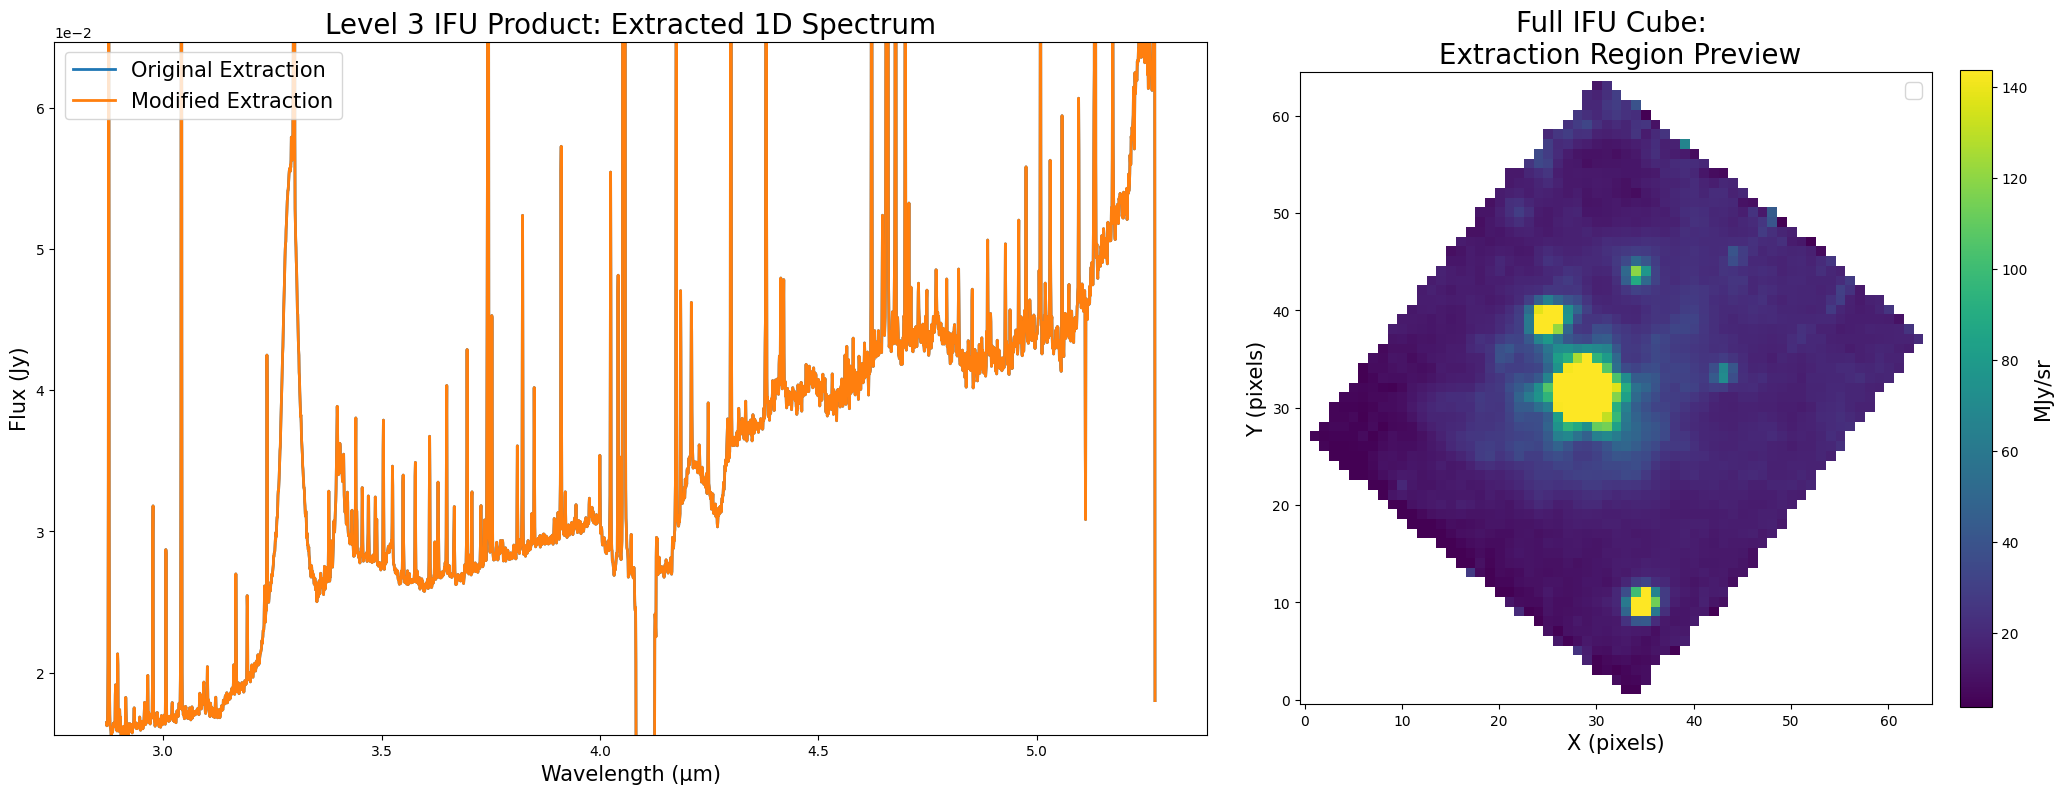

In [131]:
# Load necessary files
stage3_x1d_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
x1d_file = stage3_x1d_mod[0]
cube_data = datamodels.open(cube).data
x1d_mod = datamodels.open(x1d_file)
x1d_wave_mod = x1d_mod.spec[0].spec_table.WAVELENGTH
x1d_flux_mod = x1d_mod.spec[0].spec_table.FLUX

# Setup the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9),
                               gridspec_kw={'width_ratios': [5, 3],
                                            'wspace': 0.1})

# Plot the original and modified spectra
ax1.plot(x1d_wave, x1d_flux, linewidth=2, label="Original Extraction")
ax1.plot(x1d_wave_mod, x1d_flux_mod, linewidth=2, label="Modified Extraction")
ax1.set_xlabel('Wavelength (μm)', fontsize=15)
ax1.set_ylabel('Flux (Jy)', fontsize=15)
ax1.set_title("Level 3 IFU Product: Extracted 1D Spectrum", fontsize=20)
ax1.set_ylim(np.nanpercentile(x1d_flux, 2), np.nanpercentile(x1d_flux, 98))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, -2))
ax1.legend(fontsize=15)

# Plot the IFU cube slice
slice_mean = np.nanmean(cube_data[400:500, :, :], axis=0)
vmin = np.nanpercentile(slice_mean, 2)
vmax = np.nanpercentile(slice_mean, 98)
if vmin < -vmax:
    vmin = -vmax
slice_full = ax2.imshow(slice_mean,
                        norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch()),
                        origin='lower', cmap='viridis')
plt.colorbar(slice_full, ax=ax2,
             fraction=0.046, pad=0.04).set_label('MJy/sr', fontsize=15)

# Annotate the extraction regions
with asdf.open(extract_1d_ref_mod, mode='r') as ref_file:
    radii_data = ref_file.tree['data']
    print("Radius [arcsec]:", radii_data['radius'][0])
    print("Inner background [arcsec]:", radii_data['inner_bkg'][0])
    print("Outer background [arcsec]:", radii_data['outer_bkg'][0])

    if x1d_mod.spec[0].source_type == 'POINT':
        x_cen, y_cen = x1d_mod.spec[0].extraction_x, x1d_mod.spec[0].extraction_y
        for label, radius, color in zip(['Radius', 'Inner Background Radius',
                                         'Outer Background Radius'],
                                        ['radius', 'inner_bkg', 'outer_bkg'],
                                        ['black', 'blue', 'red']):
            ax2.add_patch(Circle((x_cen, y_cen), radii_data[radius][0] * 10,
                                 fill=False, color=color, label=label))

    ax2.set_xlabel('X (pixels)', fontsize=15)
    ax2.set_ylabel('Y (pixels)', fontsize=15)
    ax2.set_title("Full IFU Cube: \n Extraction Region Preview", fontsize=20)
    ax2.legend(fontsize=15)

plt.show()

**The spectra will look identical if the source is extended.**

In [132]:
time5 = time.perf_counter()
print(f"Runtime so far: {round((time5-time0)/60.0, 1):0.4f} min")

Runtime so far: 176.0000 min


---
## Related Notebooks


* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-IFU-Pipeline-Notebook)